In [27]:
# !wget https://05e307ba572f.ngrok-free.app/datasources.txt
!wget https://05e307ba572f.ngrok-free.app/tweets.csv

--2025-10-04 15:05:12--  https://05e307ba572f.ngrok-free.app/tweets.csv
Resolving 05e307ba572f.ngrok-free.app (05e307ba572f.ngrok-free.app)... 13.56.1.181, 50.18.3.250, 13.52.29.253, ...
Connecting to 05e307ba572f.ngrok-free.app (05e307ba572f.ngrok-free.app)|13.56.1.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12753261 (12M) [text/csv]
Saving to: ‘tweets.csv’

tweets.csv          100%[===================>]  12.16M  2.19MB/s    in 5.7s    

2025-10-04 15:05:22 (2.12 MB/s) - ‘tweets.csv’ saved [12753261/12753261]



In [21]:
# ==========================================================
# 🔧 1. Setup
# ==========================================================
!pip install scikit-learn matplotlib tqdm --quiet

In [30]:
import pandas as pd

file_path = "./tweets.csv"
df = pd.read_csv(file_path)

# Extract the 'Tweet' column and store it in an array
data = df['Tweet'].values

# Display the first 3 rows
display(df.head(3))

,Unnamed: 0,Date,User,Tweet,Likes,Retweets
0,0,2023-03-29 15:42:36+00:00,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...,0.0,0.0
1,1,2023-03-29 15:42:05+00:00,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th...",0.0,0.0
2,2,2023-03-29 15:34:29+00:00,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,0.0,0.0


Loaded 50001 entries.
Sampled 2500 out of 50001 entries (5.0%)
Working with 2500 sampled entries
Computing NCD matrix for sampled data...


100%|██████████| 3123750/3123750 [04:27<00:00, 11684.27it/s]



📊 CLUSTER SAMPLES:

Cluster 1 (1547 items):
----------------------------------------
   1. The Indian politics &amp; bureaucracy is controlled by Hindians.

Hindians take the decision of granting citizenship to a foreigner. And when they do, they're sure what they want from the new immigrant.

For Hindians,

Hindi imperialism = Nationalism

Which is blatant Hindi Racism. https://t.co/BuHEQEdACG
   2. RAHUL GANDHI 
DESERVES TO BE PUNISHED...
HE HAS NO MANNERS AT ALL...
YOU CAN KEEP SAYING 
WHATEVER YOU MAY LIKE.
BUT FACT REMAINS
RAHUL GANDHI IS A LIABILITY FOR INDIAN POLITICS..
   3. #جھوٹے_نیازی_پرلعنت This behavior and style of politics of Chairman Tehreek-e-Insaf Imran Khan is very sad. Kashmiri occupiers are bravely making unprecedented sacrifices against the Indian Army and continue to demand and struggle for freedom
   4. The force behind these things are Hindu hating communists in USA like @cmkshama .
They bring indian politics to usa to target Hindus who are minority in themsel

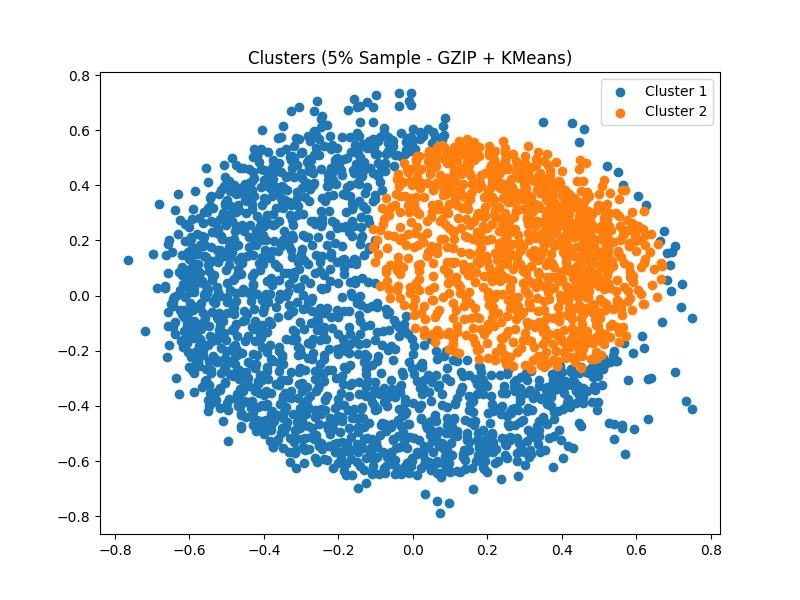

In [39]:
import gzip
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
import random

print(f"Loaded {len(data)} entries.")

# ==========================================================
# 🧮 Helper Functions
# ==========================================================
def clean_data(data):
    """Convert all data to strings and remove None values"""
    cleaned = []
    for item in data:
        if item is not None:
            cleaned.append(str(item).strip())
    return cleaned

def sample_data(data, sample_ratio=0.05, random_state=42):
    """Randomly sample data"""
    # Clean data first
    data = clean_data(data)

    random.seed(random_state)
    sample_size = int(len(data) * sample_ratio)
    sampled_indices = random.sample(range(len(data)), sample_size)
    sampled_data = [data[i] for i in sampled_indices]
    print(f"Sampled {len(sampled_data)} out of {len(data)} entries ({sample_ratio*100:.1f}%)")
    return sampled_data, sampled_indices

def compress_size(s: str) -> int:
    return len(gzip.compress(s.encode("utf-8")))

def ncd(x: str, y: str) -> float:
    cx = compress_size(x)
    cy = compress_size(y)
    cxy = compress_size(x + y)
    return (cxy - min(cx, cy)) / max(cx, cy)

# ==========================================================
# 📊 Sample 5% of data
# ==========================================================
sampled_data, sampled_indices = sample_data(data, sample_ratio=0.05)
n_sampled = len(sampled_data)  # Use sampled data size!

print(f"Working with {n_sampled} sampled entries")

# ==========================================================
# 🧮 Compute NCD matrix ONLY for sampled data
# ==========================================================
D_sampled = np.zeros((n_sampled, n_sampled))

print("Computing NCD matrix for sampled data...")
for i, j in tqdm(itertools.combinations(range(n_sampled), 2), total=n_sampled*(n_sampled-1)//2):
    dist = ncd(sampled_data[i], sampled_data[j])
    D_sampled[i, j] = D_sampled[j, i] = dist

# ==========================================================
# 🤖 Run KMeans clustering on sampled data
# ==========================================================
k = 2  # number of clusters
model = KMeans(n_clusters=k, random_state=42)
labels_sampled = model.fit_predict(D_sampled)

# ==========================================================
# 📋 Show samples from each cluster
# ==========================================================
clusters = {}
for i, (label, text) in enumerate(zip(labels_sampled, sampled_data)):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(text)

print("\n📊 CLUSTER SAMPLES:")
for cluster_id in range(k):
    cluster_data = clusters.get(cluster_id, [])
    print(f"\nCluster {cluster_id + 1} ({len(cluster_data)} items):")
    print("-" * 40)

    # Show first 10 samples
    samples = cluster_data[:10]
    for i, sample in enumerate(samples, 1):
        print(f"  {i:2d}. {sample}")

    if len(cluster_data) > 10:
        print(f"  ... and {len(cluster_data) - 10} more items")

# ==========================================================
# 📊 Visualize clusters (MDS on sampled data)
# ==========================================================
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(D_sampled)

plt.figure(figsize=(8, 6))
for cluster_id in range(k):
    mask = labels_sampled == cluster_id
    plt.scatter(coords[mask, 0], coords[mask, 1], label=f"Cluster {cluster_id+1}")
plt.title("Clusters (5% Sample - GZIP + KMeans)")
plt.legend()
plt.savefig("clusters_5percent.png")
plt.close()
print("Cluster plot saved as clusters_5percent.png")

# ==========================================================
# 📂 Save sorted clustered data (sampled data)
# ==========================================================
clustered = sorted(zip(labels_sampled, sampled_data), key=lambda x: x[0])
with open("sorted_clusters_5percent.txt", "w", encoding="utf-8") as f:
    for cid, word in clustered:
        f.write(f"Cluster {cid+1}: {word}\n")

print("Sorted cluster data saved as sorted_clusters_5percent.txt")

# ==========================================================
# ✅ Done!
# ==========================================================
from IPython.display import Image, display
display(Image("clusters_5percent.png"))

In [37]:
import gzip
import itertools
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import random

# ==========================================================
# 🎯 Get Optimal K Only
# ==========================================================

def clean_data(data):
    """Convert all data to strings and remove None values"""
    cleaned = []
    for item in data:
        if item is not None:
            cleaned.append(str(item).strip())
    return cleaned

def sample_data(data, sample_ratio=0.10, random_state=42):
    """Randomly sample data"""
    random.seed(random_state)
    sample_size = int(len(data) * sample_ratio)
    sampled_indices = random.sample(range(len(data)), sample_size)
    sampled_data = [data[i] for i in sampled_indices]
    print(f"Sampled {len(sampled_data)} out of {len(data)} entries ({sample_ratio*100:.1f}%)")
    return sampled_data, sampled_indices

def compress_size(s: str) -> int:
    return len(gzip.compress(s.encode("utf-8")))

def ncd(x: str, y: str) -> float:
    cx = compress_size(x)
    cy = compress_size(y)
    cxy = compress_size(x + y)
    return (cxy - min(cx, cy)) / max(cx, cy)

def compute_ncd_matrix(data_subset):
    """Compute NCD matrix for a subset of data"""
    n_sub = len(data_subset)
    D_sub = np.zeros((n_sub, n_sub))

    print(f"Computing NCD matrix for {n_sub} samples...")
    for i, j in tqdm(itertools.combinations(range(n_sub), 2), total=n_sub*(n_sub-1)//2):
        dist = ncd(data_subset[i], data_subset[j])
        D_sub[i, j] = D_sub[j, i] = dist

    return D_sub

def find_optimal_k(D, max_k=15):
    """Find optimal number of clusters"""
    n_samples = D.shape[0]
    K_values = range(2, min(max_k, n_samples-1))
    best_k = 2
    best_score = -1

    print("Finding optimal k...")
    for k in K_values:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(D)

        if len(set(labels)) > 1:
            score = silhouette_score(D, labels, metric="precomputed")
            print(f"score {score} k = {k}") # a good debug info
            if score > best_score:
                best_score = score
                best_k = k

    print(f"🎯 Optimal k: {best_k} (silhouette score: {best_score:.3f})")
    return best_k

cleaned_data = clean_data(data)

sampled_data, sampled_indices = sample_data(cleaned_data, sample_ratio=0.10)
D_sampled = compute_ncd_matrix(sampled_data)
optimal_k = find_optimal_k(D_sampled)

print(f"\n✅ FINAL OPTIMAL K: {optimal_k}")

Sampled 5000 out of 50001 entries (10.0%)
Computing NCD matrix for 5000 samples...


100%|██████████| 12497500/12497500 [18:06<00:00, 11499.65it/s]


Finding optimal k...
🎯 Optimal k: 2 (silhouette score: 0.052)

✅ FINAL OPTIMAL K: 2
